# CS152 Final 

## A Simplified Wumpus World Simulation in Python 

For this project, I aim to simulate the wumpus world where I design an agent to independently navigate the world. For this wumpus there are a few simplifications that were applied. Instead of finding its way back home, the win condition is the agent finding the gold. 

The worlds are designed such that there are no overlaps between wumpuses, pits and gold. The arrow mechanism is also ignored in this world. To start off, we implemented helper functions. We added a Literal class for representation in the KB and wumpus world. It seems cleaner since strings are messier to deal with. The other functions are for finding valud moves, visited cells, and path finding. 

For the path finding, I'm implementing a depth-first search. This is important to simulate the navigation of the agent from its current location to the target location. The dfs function returns a set of paths that the agent will be going through to reach the target location. Depth-first search is used as it simulates the agent's style of navigation which is going deeper into a cell that we have visited instead of checking each neighboring valid and visited cell (this is breadth-first which is not ideal for path finding) 

Next, the KB is designed in such a way that the agent will rule out multiple cells to be visited, safe and risky. More on this will be discussed later.

All in all, the agent will be navigating its own in this Wumpus world and its objective is to keep playing till they die or find the gold. 




In [189]:
import numpy as np
import matplotlib.pyplot as plt
import copy

### Setting up helping functions and classes 

In [250]:
class Literal:
    """
    This class assigns a variable to be a literal 
    We use this for representative purposes in the KB 
    """
    def __init__(self, name):
        self.name = name
        self.sign = True 
    
    def __neg__(self): 
        new_literal = Literal(self.name)
        new_literal.sign = not self.sign
        return new_literal 
        
    def __eq__(self, other): 
        return self.name == other.name
        
    def __hash__(self):
        return hash(self.name)
        
    def __repr__(self):
        if self.sign == True:
            return self.name
        else:
            return "~"+self.name

        
def find_neighbors(cur_loc):
    """
    This function helps find the adjacent cells 
    """
    neighbors = []

    neighbors.append([cur_loc[0] + 1,cur_loc[1]]) # up
    neighbors.append([cur_loc[0] - 1,cur_loc[1]]) # down 
    neighbors.append([cur_loc[0],cur_loc[1] + 1]) # right
    neighbors.append([cur_loc[0],cur_loc[1] - 1]) # left
    
    return neighbors

def valid_cells(cells):
    """
    This function rules out cells that are outside the wumpus world 
    """
    valid = [] 
    for i,cell in enumerate(cells): 
        if (cell[0] >= 0 and cell[0] < 4) and (cell[1] >= 0 and cell[1] < 4):
            valid.append(cell)
            
    return valid

def unvisited_cells(cells, visited_cells, safe_cells):
    """
    This function returns cells that have not been visited. 
    This is used for the KB (check updateKB method in Agent class)
    """
    unvisited = [] 
    
    for i, cell in enumerate(cells): 
        if cell not in visited_cells and cell not in safe_cells:
            unvisited.append(cell)
            
    return unvisited 
            
def dfs_find_path(cur_loc, target_loc, visited_cells):
    """
    We need the visited and safe cells as part of our filtering in 
    possible node expansion. Here we use breadth-first search to help our agent 
    find a path towards the target location. 
    """

    visited = [cur_loc] # this is for visited in bfs tree 
    queue = [cur_loc] 
    
    while queue:
        # we take the recently acquired children to implement depth-first
        s = queue.pop()
        curr = s
        # visited.append(s) # add expanded cell in visited
        
        if curr == target_loc:
            visited.pop()
            break

        children = find_neighbors(curr) # find adj cells 
        children = valid_cells(children) #filter out invalid cells 
        n_iter = len(children)
        for i in range(n_iter):
            child = children[i]
            
            # as we navigate, we only consider the ones we haven't 
            # visited and the valid cells that have been visited by
            # the agent before. We cannot explore cells that we 
            # have never been in 
            if (child not in visited) and (child in visited_cells):
                queue.append(child)
                visited.append(child)   

    reversed_list = [elem[::-1] for elem in visited]
                  
    return reversed_list

In [251]:
### Setting up our literals to be used for representation 
G = Literal("G") # Gold 
W = Literal("W") # Wumpus 
pW = Literal("pW") # potential Wumpus 
P = Literal("P") # Pit 
pP = Literal("pP") # potential Pit 
s = Literal("s") # stench 
b = Literal("b") # breeze 
OK = Literal("OK") # OKAY = Safe cell 


## Designing our Agent

Our agent class mainly contains two methods which are updating its current KB and choosing its next move. It is best to this as the internal processes of the agent (what is happening in their mind?). We initialize with an empty KB and our indicators that the agent is alive and has gold. We always start at [0,0]. Lastly, we also keep track of the cells that we have visited, find safe and risky. 

The update KB follows a basic format of observing its perceptions in the current cells and making assumptions at the adjacent cells. It follows the following logical equations:

let $i,j$ be the current location 

let the following literals be defined: 
- $P : Pit$
- $B : Breeze$
- $S : Stench$
- $W : Wumpus$
- $OK : Safe$

let the following be the rules the KB has to follow:
- $B_{i,j} \rightarrow P_{i-1,j} \lor P_{i+1, j} \lor P_{i, j -1} \lor P_{i,j+1}$
- $S_{i,j} \rightarrow W_{i-1,j} \lor W_{i+1, j} \lor W_{i, j -1} \lor W_{i,j+1}$
- $\text{No percept}_{i,j} \rightarrow OK_{i-1,j} \lor OK_{i+1, j} \lor OK_{i, j -1} \lor OK_{i,j+1}$

Every time an agent goes to a new cell, it will send the respective assumptions in the valid neighboring cells at the same time checking if the cell has been visited or rules as safe. If so, then there will be no assumptions added to this cell. Basically, it will only add these assumptions on unvisited adjacent cells and add these cells to the risky cells list. 

This is a very simplified version of the proper rules of the Wumpus world and it does have its limitations. More on this in the discussion later. 

The purpose of our KB is to continously update the safe and risky cells as we move along the map. The agent's way of moving around is to always prioritize safe cells. These are cells that are observed to have no wumpuses or breezes. This can be from a neighboring empty cell or a risky cell that was randomly chosen and the agent finds that there are no percepts in this current cell. In case the agent runs out of safe cells to explore, it will then take a risk by randomly choosing between the risky cells and take a leap of faith. These risky cells are presumed to have a pit or a wumpus. If the agent stumbles upon these two, then it will die. If not, then the agent is lucky and will rule the current cell as safe and visited. 

In [252]:
class Agent:
    def __init__(self):
        # setting up our knowledge base 
        # our default we already have assumptions 
        self.KB = [
            [[OK],[],[],[]],
            [[],[],[],[]],
            [[],[],[],[]],
            [[],[],[],[]]]    
        
        self.is_Alive = True  
        self.has_Gold = False 
                
        # Default starting location of our agent 
        self.cur_loc = [0,0]
        
        # Keep track of the cells we encounter and inferred 
        self.visited_cells = [self.cur_loc] # visited cells are already known as safe 
        self.safe_cells = []
        self.risky_cells = [] 
        
    def KBshow(self, loc):
        return self.KB[loc[0]][loc[1]]
    
    def Worldshow(self):
        KB_copy = copy.deepcopy(self.KB)
        
        KB_copy[self.cur_loc[0]][self.cur_loc[1]].append("A")
        
        return KB_copy
    
    def update_KB(self, loc, wumpus_world):
        """
        This method will be updating the KB based 
        on its newly acquired perceptions
        """
        
        adj = find_neighbors(loc)
        adj = valid_cells(adj)
        
        # what the agent finds in its current location 
        percept = wumpus_world.show(loc)

        # add assumptions based on acquired percepts 
        if percept == []: # no observations, adj cells are safe 
            del self.KBshow(loc)[:]
            self.KBshow(loc).append(OK)
            
            # Remove current cell from risky cells 
            if loc in self.risky_cells:
                for i, cell in enumerate(self.risky_cells):
                    if loc == cell:
                        self.risky_cells.pop(i)
                        
            # Update surroundings of 0 percept cell 
            for cell in adj:
                if OK not in self.KBshow(cell):
                    self.KBshow(cell).append(OK)
                if cell not in self.safe_cells:
                    self.safe_cells.append(cell)
                
        else:       
            # we don't add assumptions for visited and safe cells 
            valid_unvisited = unvisited_cells(adj, self.visited_cells, self.safe_cells) 
            
            # add our assumptions to adjacent cells 
            for p in percept:
                if p == G:
                    self.has_Gold = True 
                    
                if p == W or p == P:
                    self.is_Alive = False 
                
                if p == s: 
                    self.KBshow(loc).append(s)
                    for cell in valid_unvisited:
                        if pW not in self.KBshow(cell):
                            self.KBshow(cell).append(pW)
                        if cell not in self.risky_cells:
                            self.risky_cells.append(cell)
                        
                elif p == b: 
                    self.KBshow(loc).append(b)
                    for cell in valid_unvisited:
                        if pP not in self.KBshow(cell):
                            self.KBshow(cell).append(pP)
                        if cell not in self.risky_cells:
                            self.risky_cells.append(cell)
    
    def get_next_move(self):
        """
        This method will make the agent choose 
        the next move based on its collected list of cells and risky cells 
        The idea is to always search around the safe cells and if we cannot 
        find any, we take our chances with the risky cells. 
        """
        
        if len(self.safe_cells) > 0: 
            return self.safe_cells.pop(0)
        
        else: 
            if len(self.risky_cells) > 1:
                return self.risky_cells.pop(np.random.randint(0, len(self.risky_cells) - 1))
            else:
                return self.risky_cells.pop()
    
        

### Applying the simulation 


In [258]:
def sample_simulate_Wumpus(agent, world):
    """
    This function will be implementing the simulation of the wumpus world 
    """
    
    # metrics 
    visited_cells = [] 
    
    
    # Initialize our agent and world     
    ag = agent 
    wump_world = world 
    ag.update_KB(ag.cur_loc, wump_world)
    print("WUMPUS WORLD")
    for i in wump_world.world:
        print(i)
    steps = 0
    while ag.is_Alive and not ag.has_Gold:
        next_loc = ag.get_next_move() 
        ag.visited_cells.append(next_loc)
        
        # Acquire our agent's path 
        print(f"---------- ITER: {steps} ----------")

        path = dfs_find_path(ag.cur_loc, next_loc, ag.visited_cells)
        
        for cell in path:
            visited_cells.append(cell)

        ag.cur_loc = next_loc 
        
        ag.update_KB(ag.cur_loc, wump_world)
        print(f"Curr perception: {wump_world.show(ag.cur_loc)} at position {ag.cur_loc}")

        print("VISITED CELLS", ag.visited_cells)
        print("SAFE CELLS", ag.safe_cells)
        print("RISKY CELLS", ag.risky_cells)
        
        print("ALIVE:", ag.is_Alive)
        print("HAS GOLD:", ag.has_Gold)
        print("---")
        print("KB and Agent position:", ag.cur_loc)
        for i in ag.Worldshow():
            print(i)
            
        steps += 1
    print("-----END SCORE -----")
    
    # Agent died 
    if ag.is_Alive == False and ag.has_Gold == False:
        win = 0 
        print("AGENT LOST ")
    
    # Agent got the gold and surived 
    if ag.is_Alive == True and ag.has_Gold == True:
        win = 1 
        print("AGENT WON")
        
    print("Steps taken:", len(visited_cells))
    
    visited_cells.append(ag.cur_loc)
    
    print("Path: ", visited_cells)
    return visited_cells, steps, win 

### Sample of a few steps of our agent 

Here is a tractable progression of the agent as it navigates the wumpus world. The world is set to easy so we can see that the agent actually wins. 

In [261]:
world = [
    [[],[b],[P],[b]],
    [[s],[],[b],[]],
    [[W],[s],[],[]],
    [[s],[],[G],[]]
]

easy_world = [
    [[],[],[],[]],
    [[s],[G, b],[],[]],
    [[W, b],[P, s],[],[]],
    [[s],[b],[],[]]
]

ag = Agent()
wump_world = WumpusWorld(easy_world)

_,_,_ = sample_simulate_Wumpus(ag, wump_world)


WUMPUS WORLD
[[], [], [], []]
[[s], [G, b], [], []]
[[W, b], [P, s], [], []]
[[s], [b], [], []]
---------- ITER: 0 ----------
Curr perception: [s] at position [1, 0]
VISITED CELLS [[0, 0], [1, 0]]
SAFE CELLS [[0, 1]]
RISKY CELLS [[2, 0], [1, 1]]
ALIVE: True
HAS GOLD: False
---
KB and Agent position: [1, 0]
[[OK], [OK], [], []]
[[OK, s, 'A'], [pW], [], []]
[[pW], [], [], []]
[[], [], [], []]
---------- ITER: 1 ----------
Curr perception: [] at position [0, 1]
VISITED CELLS [[0, 0], [1, 0], [0, 1]]
SAFE CELLS [[1, 1], [0, 2], [0, 0]]
RISKY CELLS [[2, 0], [1, 1]]
ALIVE: True
HAS GOLD: False
---
KB and Agent position: [0, 1]
[[OK], [OK, 'A'], [OK], []]
[[OK, s], [pW, OK], [], []]
[[pW], [], [], []]
[[], [], [], []]
---------- ITER: 2 ----------
Curr perception: [G, b] at position [1, 1]
VISITED CELLS [[0, 0], [1, 0], [0, 1], [1, 1]]
SAFE CELLS [[0, 2], [0, 0]]
RISKY CELLS [[2, 0], [1, 1], [2, 1], [1, 2]]
ALIVE: True
HAS GOLD: True
---
KB and Agent position: [1, 1]
[[OK], [OK], [OK], []]
[[

## Running Simulations and Analysis 

In [262]:
def simulate_Wumpus(agent, world):
    """
    This function will be implementing the simulation of the wumpus world 
    """
    
    # metrics 
    visited_cells = [] 
    win = None
    steps = 0
    
    # Initialize our agent and world     
    ag = agent 
    wump_world = world 
    ag.update_KB(ag.cur_loc, wump_world)

    while ag.is_Alive and not ag.has_Gold:
        next_loc = ag.get_next_move() 
        ag.visited_cells.append(next_loc)
        
        # Acquire our agent's path 
        path = dfs_find_path(ag.cur_loc, next_loc, ag.visited_cells)
        
        for cell in path:
            visited_cells.append(cell)

        ag.cur_loc = next_loc 
        
        ag.update_KB(ag.cur_loc, wump_world)

            
        steps += 1
    
    # Agent died 
    if ag.is_Alive == False and ag.has_Gold == False:
        win = 0 
    
    # Agent got the gold and surived 
    if ag.is_Alive == True and ag.has_Gold == True:
        win = 1 
        
    
    return visited_cells, steps, win 

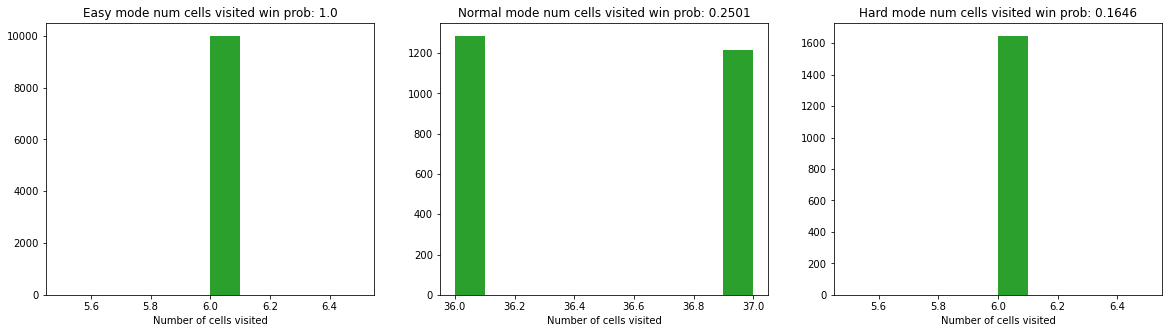

In [263]:
world = [
    [[],[b],[P],[b]],
    [[s],[],[b],[]],
    [[W],[s],[],[]],
    [[s],[],[G],[]]
]

easy_world = [
    [[],[],[],[]],
    [[s],[G, b],[],[]],
    [[W, b],[P, s],[],[]],
    [[s],[b],[],[]]
]

hard_world = [
    [[b],[P],[b],[G]],
    [[b],[P],[b],[G]],
    [[s],[W],[s],[G]],
    [[G],[G,s],[G],[G]]
]


def mult_sims(world, n_steps):
    wins = []
    steps_taken = []
    for i in range(n_steps): 
        ag = Agent()
        wump_world = WumpusWorld(world)

        visited_cells, _, win = simulate_Wumpus(ag, wump_world)

        wins.append(win)

        if win ==1:
            steps_taken.append(len(visited_cells))
            
    
    return wins, steps_taken 

n_steps = 10000

# normal
normal = mult_sims(world, n_steps)

# easy 
easy = mult_sims(easy_world, n_steps)

# hard 
hard = mult_sims(hard_world, n_steps)

fig, ax = plt.subplots(1,3 , figsize = [20,5])

for i in range(3):
    ax[0].set_title(f"Easy mode num cells visited win prob: {sum(easy[0])/n_steps}")
    ax[0].hist(easy[1])
    
    ax[1].set_title(f"Normal mode num cells visited win prob: {sum(normal[0])/n_steps}")
    ax[1].hist(normal[1])
    
    ax[2].set_title(f"Hard mode num cells visited win prob: {sum(hard[0])/n_steps}")
    ax[2].hist(hard[1])
    
    ax[i].set_xlabel("Number of cells visited")

## Analysis 

Our results show what is expected. Easy mode would result in 100% win rate because the G is part of the safe cells and the agent will always look into the safe cells. As for the normal mode, there is a slight different in the number of cells visited to actually win. Also, the agent only wins 1 out of 4 games. This is because the set-up of the medium world is that the agent will always have to choos between risky cells where they have 1 out of 4 chances of getting the safe cell. The hard mode shows the lowest win rate which is 15% and this is because the agent will have to take risky decisions all the time and all the cells visited are not safe. 

## Further Improvements 

This simulation of the wumpus world was simplified especially in the KB processing. It does not implement all the logical rules that can be derived from the wumpus world. We can further improve the KB by adding a process as to which we can rule out the wumpus. Since there is only one wumpus, if we find a cell that has two neighboring stench cells (assuming that we are following a von Neummann neighborhood system), then we can say that that specific cell has a wumpus. We can also improve the mode of choosing between risky cells. We can never avoid an empty safe cell and there will come a time we need to take a chance. We can implement probability theory in choosing the risky cells. An example would be to apply the perceptions of the cell and its neighboring cells and determine the probability of the cell having a wumpus or a pit. We then program the agent to choose the risky cell that has the least amount of risk. Probability-wise, this should increase our chances of winning. 